<a href="https://colab.research.google.com/github/jkrue242/PortfolioOptimization/blob/main/portfolio_optimiztion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Optimization using Deep Learning

#### Implementation and modification of [this paper](https://arxiv.org/pdf/2005.13665).

#### Modifications will include:
1. Use of different recursive networks (Transformer, GRU, LSTM)
2. Hyperparameter optimization
3. Additional input features
4. Loss function comparison between Sharpe and Sortino

Imports

In [13]:
import warnings
from data_utils import *
from transformer import *
from sharpe import *
from plots import *

warnings.filterwarnings("ignore")

In our analysis, we will build a simple portfolio of 4 indices:
1. AGG (Agg. Bond ETF)
2. DBC (Commodity Index)
3. VTI (Vanguard Total Stock Index)
4. VIX (CBOE Volatility Index)

In [14]:
ETFS = ["VOO", "QQQ", "GLD"]
N_TICKERS = len(ETFS)

SAMPLE_DAYS = 50
ROLLING_AVGS = [10, 30, 50]
BATCH_SIZE = 64
START_DATE = "2010-01-01"
END_DATE = "2025-01-01"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running script on {DEVICE}")

Running script on cpu


In [15]:
data = load_data(ETFS, START_DATE, END_DATE, ROLLING_AVGS)
data

[*********************100%***********************]  3 of 3 completed

Number of features per asset: 5


VOO                                                        \
Price         return cumulative_return       ma_10       ma_30       ma_50   
Date                                                                         
2010-01-04  0.000000          0.000000   78.969456   80.586119   82.020493   
2010-01-05  0.000000          0.000000   78.969456   80.586119   82.020493   
2010-01-06  0.000000          0.000000   78.969456   80.586119   82.020493   
2010-01-07  0.000000          0.000000   78.969456   80.586119   82.020493   
2010-01-08  0.000000          0.000000   78.969456   80.586119   82.020493   
...              ...               ...         ...         ...         ...   
2024-12-24  0.010289          6.112847  547.312683  546.749709  540.711294   
2024-12-26 -0.000018          6.112718  546.920239  546.942733  541.140416   
2024-12-27 -0.010365          6.038994  546.242871  546.936147  541.410834   
2024-12-30 -0.011132          5.960636  544.962579  546.842822  541.558280   
2024-12-31 -0.004030          5.932588  543.248492  546.910195  541.621351   

                 QQQ                                                        \
Price         return cumulative_return       ma_10       ma_30       ma_50   
Date                                                                         
2010-01-04  0.000000          0.000000   40.331441   38.992670   39.371014   
2010-01-05  0.000000          0.000000   40.331441   38.992670   39.371014   
2010-01-06 -0.006032         -0.006032   40.331441   38.992670   39.371014   
2010-01-07  0.000650         -0.005386   40.331441   38.992670   39.371014   
2010-01-08  0.008230          0.002800   40.331441   38.992670   39.371014   
...              ...               ...         ...         ...         ...   
2024-12-24  0.013560         12.070523  524.844501  514.741706  506.698455   
2024-12-26 -0.000679         12.061643  524.897736  515.324696  507.488082   
2024-12-27 -0.013293         11.888014  524.588959  515.695298  508.135922   
2024-12-30 -0.013300         11.716605  523.184460  515.952878  508.638190   
2024-12-31 -0.008495         11.608581  520.580984  516.467426  508.988789   

                 GLD                                                      
Price         return cumulative_return       ma_10       ma_30     ma_50  
Date                                                                      
2010-01-04  0.000000          0.000000  111.097000  108.452334  108.8286  
2010-01-05 -0.000911         -0.000911  111.097000  108.452334  108.8286  
2010-01-06  0.016500          0.015574  111.097000  108.452334  108.8286  
2010-01-07 -0.006188          0.009290  111.097000  108.452334  108.8286  
2010-01-08  0.004963          0.014299  111.097000  108.452334  108.8286  
...              ...               ...         ...         ...       ...  
2024-12-24  0.001992          1.198907  243.471002  243.258666  246.3490  
2024-12-26  0.006751          1.213752  242.682002  243.359333  246.2920  
2024-12-27 -0.006871          1.198543  242.094002  243.485000  246.1770  
2024-12-30 -0.003190          1.191530  241.728003  243.605667  246.0170  
2024-12-31  0.006234          1.205191  241.453003  243.790334  245.8342  

[3774 rows x 15 columns]

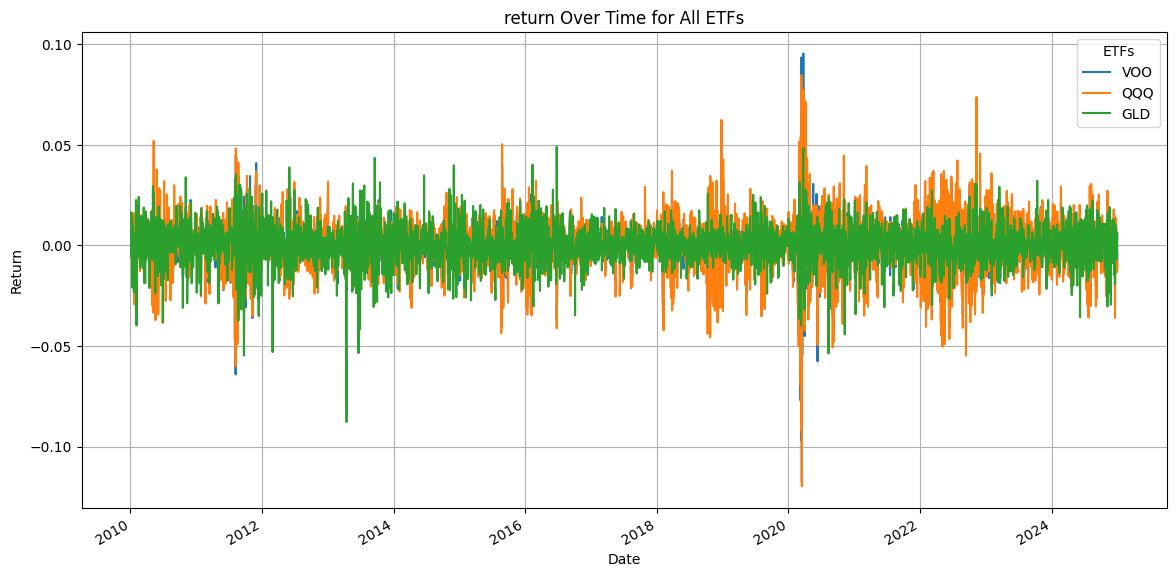

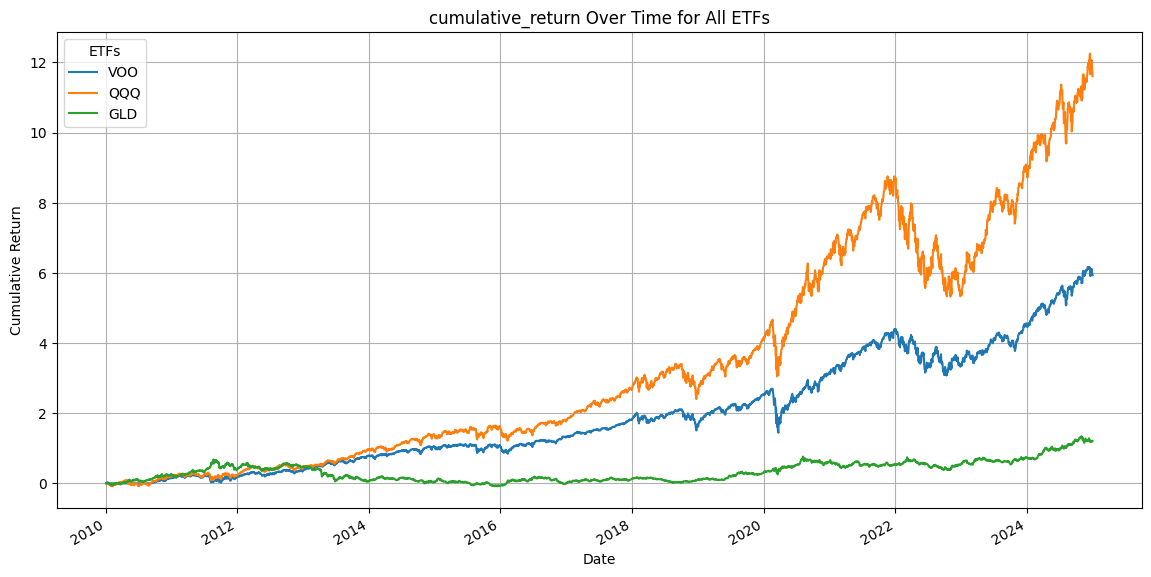

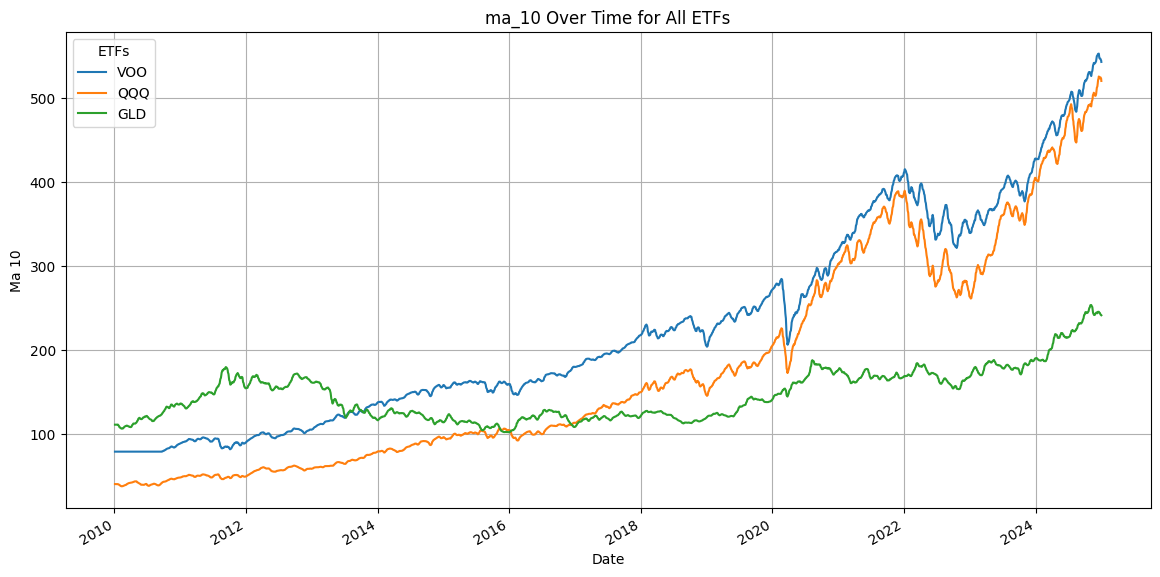

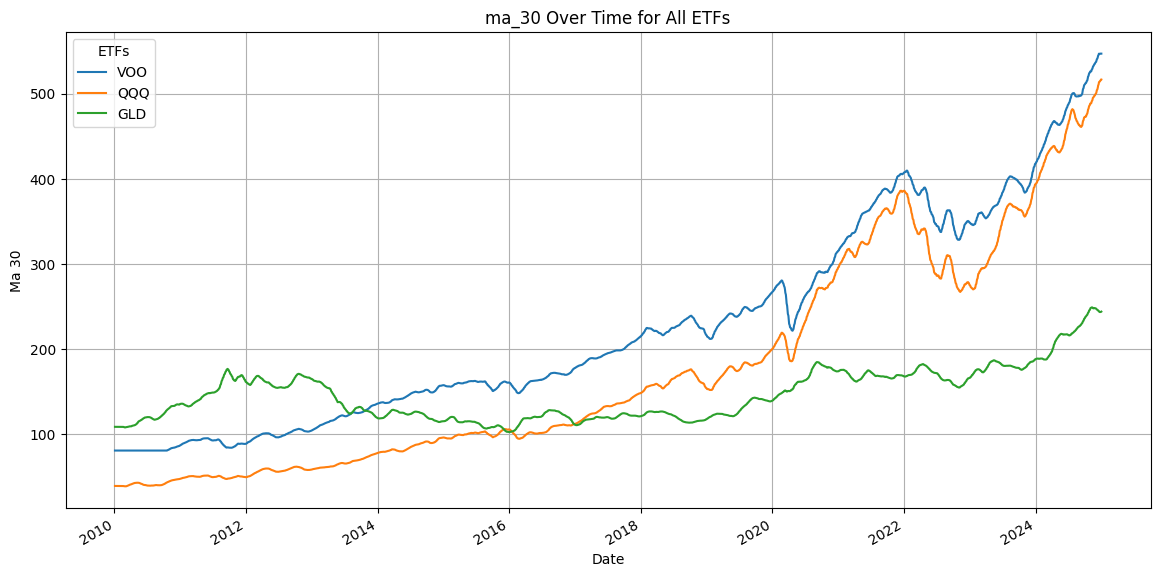

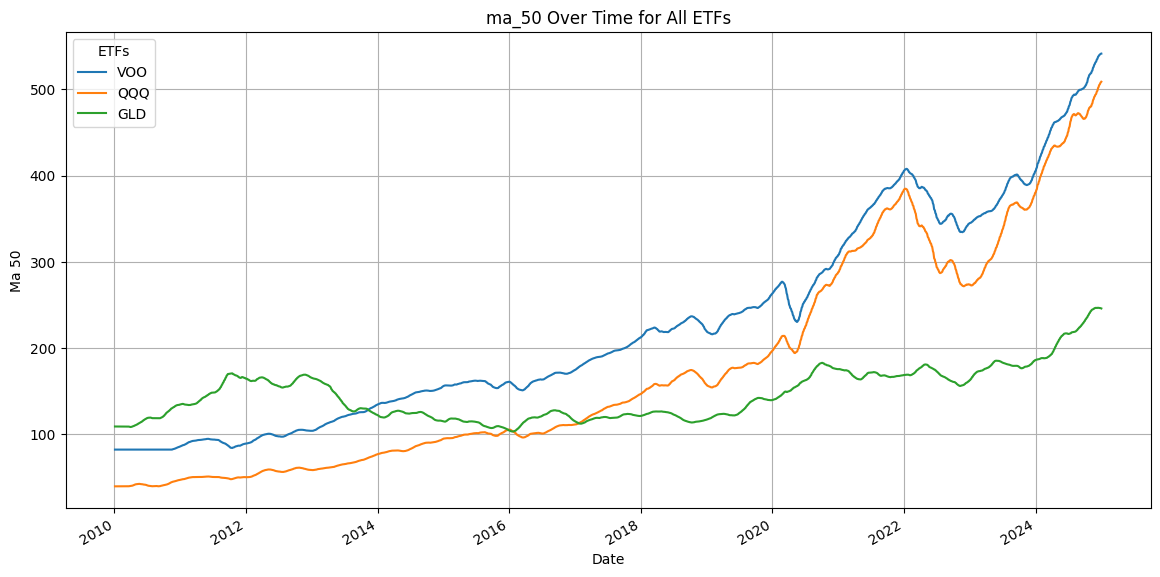

In [16]:
plot_features(data)

In [6]:
train_data, val_data, test_data = split_data(data)

Train set: 3019 samples
Validation set: 377 samples
Test set: 378 samples


: 

In [ ]:
model, history = train_model(
    train_data,
    val_data,
    ETFS,
    SAMPLE_DAYS,
    batch_size=BATCH_SIZE,
    epochs=5,
    device=DEVICE,
)

  Epoch 01, Batch 000 - Predicted Weights (first sample):
    VOO: 0.6013     QQQ: 0.1836     GLD: 0.2151 
Epoch 01, Train Loss: 0.0758, Val Loss: 0.0894, Val Sharpe: 0.0255
  Epoch 02, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4852     QQQ: 0.3513     GLD: 0.1635 
Epoch 02, Train Loss: 0.0800, Val Loss: 0.0908, Val Sharpe: 0.0269
  Epoch 03, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4460     QQQ: 0.4111     GLD: 0.1428 
Epoch 03, Train Loss: 0.0720, Val Loss: 0.0919, Val Sharpe: 0.0281
  Epoch 04, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4070     QQQ: 0.3967     GLD: 0.1963 
Epoch 04, Train Loss: 0.0860, Val Loss: 0.0917, Val Sharpe: 0.0280
  Epoch 05, Batch 000 - Predicted Weights (first sample):
    VOO: 0.3761     QQQ: 0.4018     GLD: 0.2221 
Epoch 05, Train Loss: 0.0777, Val Loss: 0.0904, Val Sharpe: 0.0280


: 

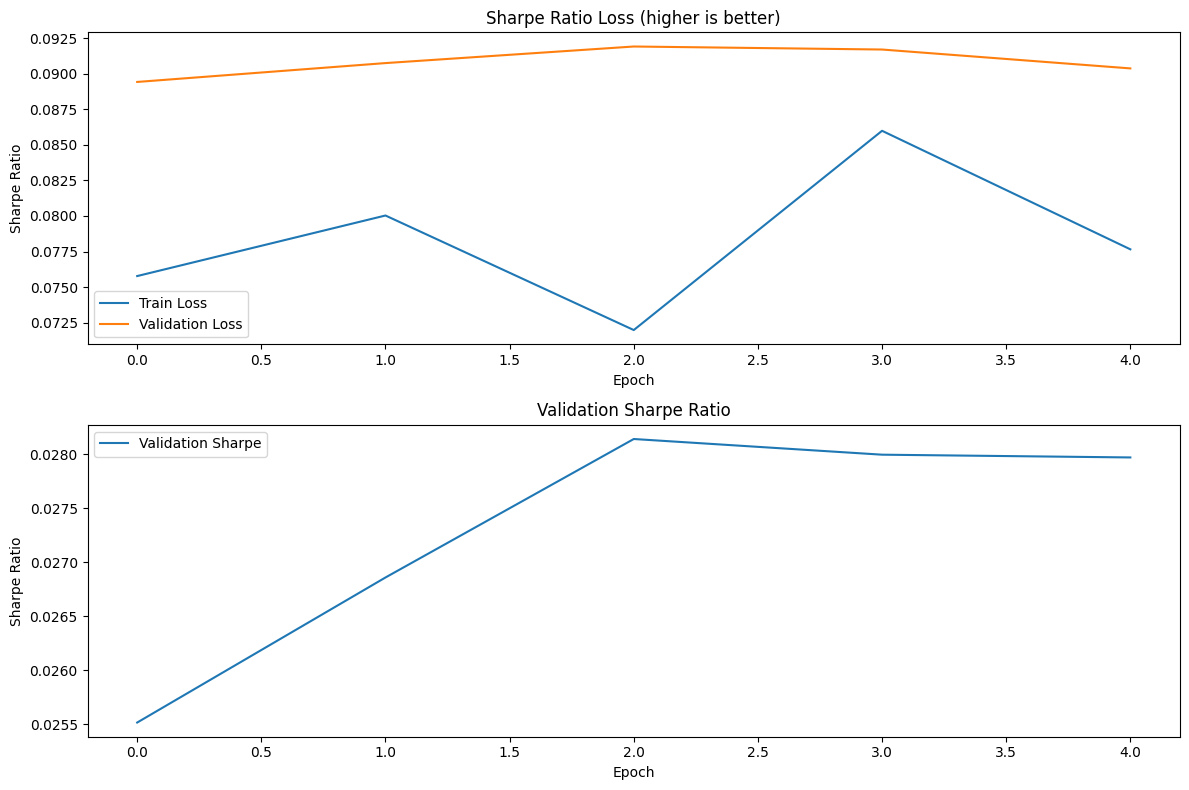

In [17]:
plot_training_history(history)

In [18]:
results = evaluate_model(model, test_data, ETFS, SAMPLE_DAYS, device=DEVICE)

Test Set Sharpe Ratio: 0.1234


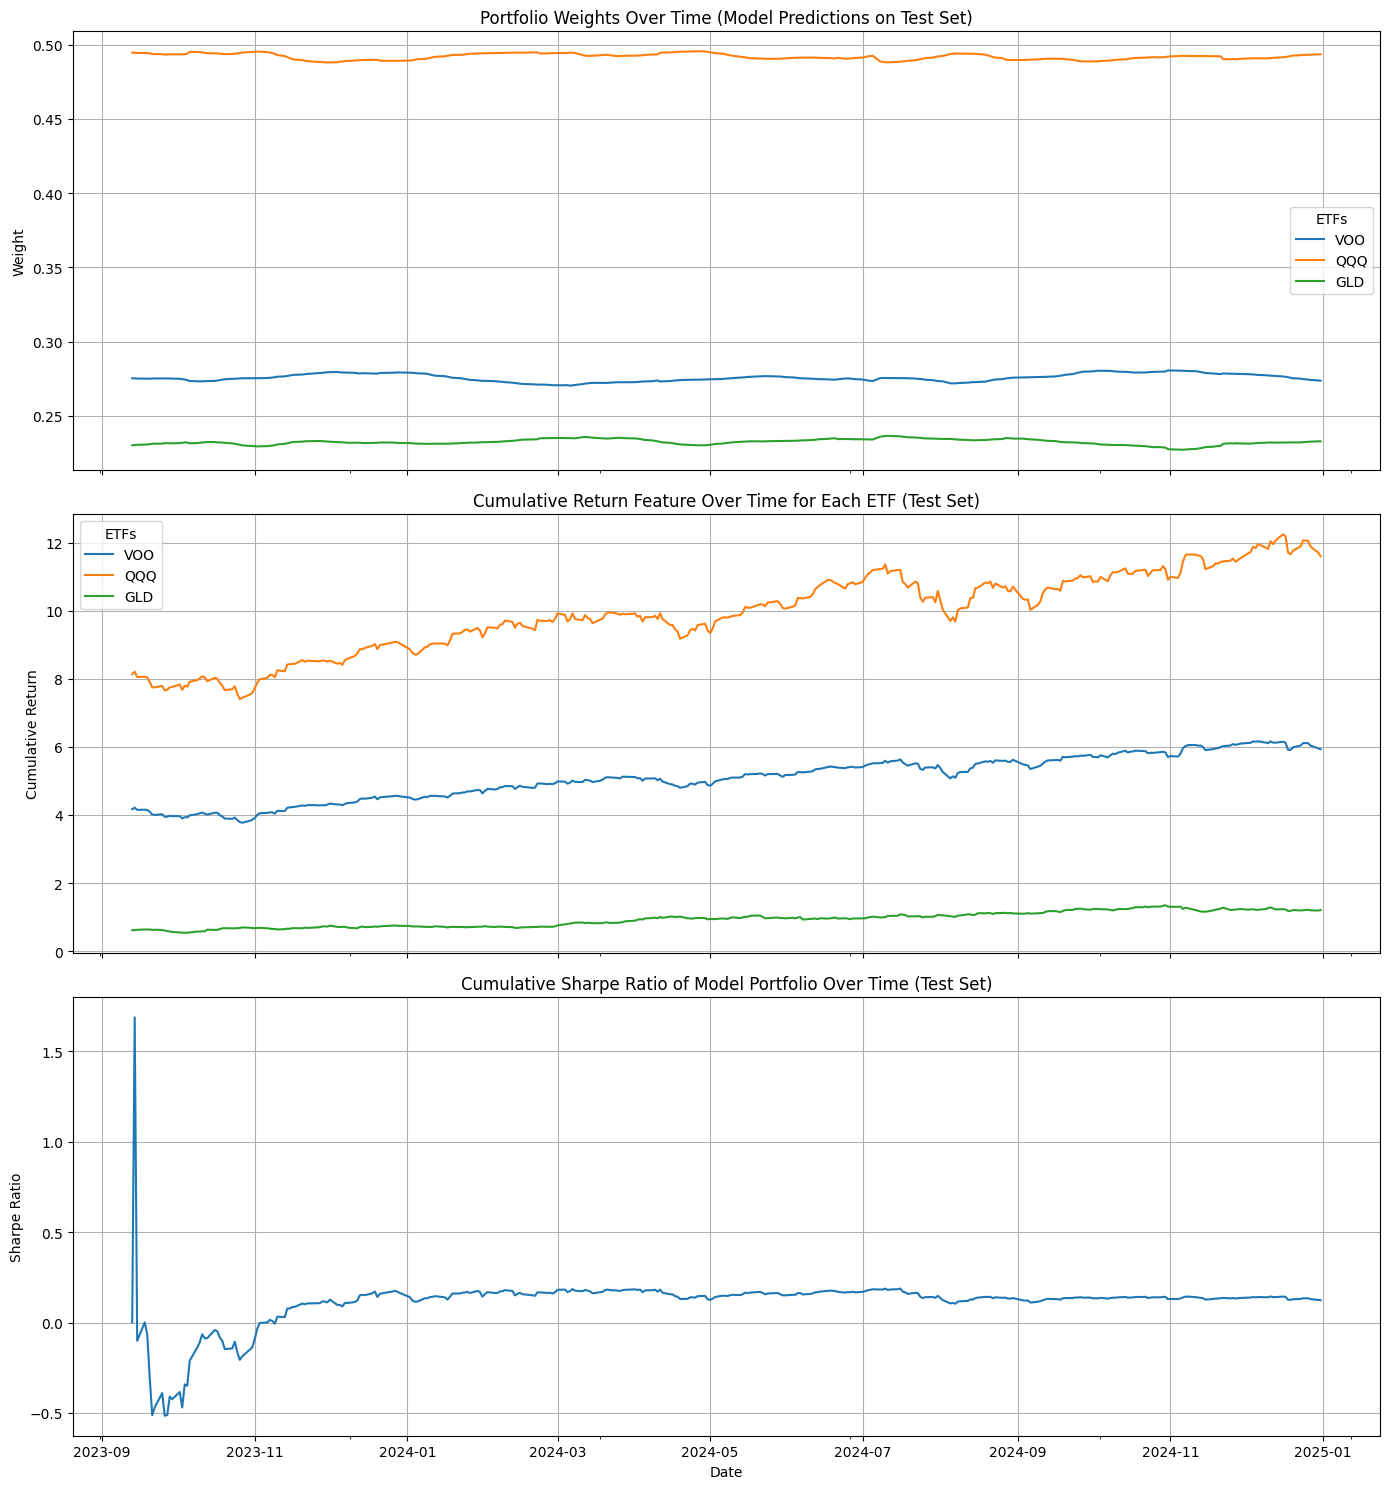

In [19]:
plot_test_results(results, test_data, ETFS)